### 研究動機：特斯拉主題分類以及預測銷售量任務
工具：
+ week4 情緒分析(CKIP)
+ week5 情緒分析(SnowNLP), NFR、
+ Week6 Bigram, TD-IDF、
+ Week7 模型與分類器訓練
+ Week10 LDA
+ Week11 字與字的關聯, Transform model(like bert but Decoder-only), Embedding分類任務
+ Week12 bert(encoder-only-model)
+ Week13 LLM 
+ Week14 社會網路圖
+ Week15 進階社群網路圖

資料來源：
+ 資料來源：PPT車版
+ 關鍵字：特斯拉、Tesla
+ 資料筆數：1585篇
+ 訓練資料日期：2023/1/1 - 2024/04/30

可能的分析方向：
+ 社群媒體分析：探索特斯拉在不同社群媒體平台上的評論和討論。如特斯拉的技術創新、環保意識等。
+ 市場趨勢預測：分析特斯拉的新產品發布、重大事件或競爭對手的動態對市場的影響，並進行股市趨勢預測。
+ 產品品質分析：使分析消費者的投訴、讚美和建議，並進行情緒分類和主題分析，探討產品品質的缺點與優點。
+ 競爭分析：分析特斯拉與其他競爭對手的比較。特斯拉和其他汽車品牌的情緒和評價，了解特斯拉市場上的定位和競爭策略。

以產品品質分析+市場趨勢(銷量)分析為例：
+ 分析過程：1. 透過Guide-LDA做主題分類，將特斯拉主題試著分類(客訴：服務(人員接待)、物流(到貨速度、零件物流)、配套(充電樁、維修站)、價格、安全(過熱、火燒車、爆炸、暴衝、失控)、使用者體驗(公差、電池、低溫))並產生主題標籤。
+ 分析過程：2. 將文章做情緒分析(SnowNLP)，分析負面與正面原因
+ 分析過程：3. n-gram捕捉特斯拉產品相關的常用詞彙、計算字與字的關聯度分數
+ 分析過程：4. 加入新文章，分別使用embedding/DTM 搭配 分類器模型來分類新文章，順便看哪個效果較好
+ 分析過程：5. 以季度為單為，透過情緒分析來預測汽車銷量(需要用到回歸模型 但課程沒教)

問題：
+ 透過非監督式學習LDA的分類後產生標籤，再將標籤後的文章透過embedding+分類訓練器，將後續匯入的新文章賦予標籤這件事情是否合理？ 會不會新文章直接丟進去LDA效果更好？LDA是否也有fine-tune 就不需要重跑一次
+ 好東西都在"artComment"但課程好像沒有去解析artComment欄位，都是針對artContent去分析，這個部分可以保留未來執行

In [3]:
import time 
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import re #re: 正規表達式套件。
import math #math: 數學運算工具。
import datetime
import os
from pprint import pprint

import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。

import jieba #jieba: 中文斷詞套件。
import jieba.analyse

import pyLDAvis
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

from wordcloud import WordCloud 
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from collections import Counter, namedtuple #collections: 提供額外的數據類型。
import networkx as nx #networkx: 網絡圖建構、繪製工具。
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

from getpass import getpass


In [5]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] 

# 設定文字雲中文字體路徑 金萱粉圓體2.0
FontPath = 'path/to/jf-openhuninn-2.0.ttf' # 設定字型
# FontPath = './SourceHanSansTW-Regular.otf' # 設定字型

plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

# Path to the custom font
font_path = 'font/jf-openhuninn-2.0.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break


Found font: jf-openhuninn-2.0


In [7]:
#匯入資料
df = pd.read_csv('./data/ppt_tesla.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

,artDate,artTitle,artContent
0,2023-01-01 10:48:19,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....
1,2023-01-01 22:42:25,[問題]特斯拉久了會掉電嗎？,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\r\nhttps://star.setn.com/news/1232578?ut...


In [8]:
MetaData = df.copy()
MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
#MetaData['artDate'] =  pd.to_datetime(MetaData['artDate']).dt.to_period('D')

# 只留下中文字
MetaData['artContent'] = MetaData['artContent'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artTitle'] = MetaData['artTitle'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artContent'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['artTitle'] = MetaData['artTitle'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['sentence'] = MetaData['sentence'].apply(lambda x: re.sub('[口]', '', x))

MetaData.head(3)

,artDate,artTitle,artContent,sentence
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...


In [9]:
raw_data = MetaData.copy()
raw_data['content'] = raw_data['artContent']
raw_data = raw_data.loc[:,["artDate", "content", ]]  # 文章內容 文章連結
raw_data.head(3)

,artDate,content
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...


In [10]:
missing_values = raw_data[raw_data["content"].isnull()]
print("具有缺失值的行：")
print(missing_values)

具有缺失值的行：
Empty DataFrame
Columns: [artDate, content]
Index: []


In [11]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")
#jieba.load_userdict('./dict/BBWord.txt')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [12]:
raw_data["words"] = raw_data["content"].apply(getToken)
raw_data.head()

Building prefix dict from d:\114 NSYSU MIS\SMA_project 4\SMA_project\王唯宇\dict\dict.txt ...
Loading model from cache C:\Users\hands\AppData\Local\Temp\jieba.u2f49588dc3bdce7d118f2a785d58044c.cache
Loading model cost 0.626 seconds.
Prefix dict has been built successfully.


,artDate,content,words
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"[八卦, 官網, 特斯拉, 二手車, 三方, 平台, 便宜, 黨會, 勝利]"
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"[前輩, 中古, 特斯拉, 里程, 擔心, 電池, 電越, 充越, 少電, 里程數, 越少開..."
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"[王家, 徐兆緯, 台北, 電競, 世界, 冠軍, 日前, 直播, 自動, 駕駛, 雙手, ..."
3,2023-01-02 18:01:04,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"[如題, 特斯拉, 最近, 出門, 車位, 很煩, 騎家裡, 超舊, 機車, 機車道, 機車..."
4,2023-01-02 19:21:24,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"[美國, 汽車, 召回, 排名, 揭曉, 超過, 萬輛車, 進廠, 處理, 結束, 迎來, ..."


In [13]:
# 將['words']轉成list
docs = raw_data['words'].to_list()

dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

Dictionary<4793 unique tokens: ['三方', '二手車', '便宜', '八卦', '勝利']...>


In [14]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

三方: 0
二手車: 1
便宜: 2
八卦: 3
勝利: 4
官網: 5
平台: 6
特斯拉: 7
一點: 8
中古: 9
之後: 10
公里: 11


In [15]:
print(" ".join(raw_data['words'].iloc[600]))

月訂 月底 領車 公里 考慮 外型 過不了 老婆 那關 後續 開都用 檔開 完全 節電 北市 台北市 市區 道路 通勤 一度電 認真 一點 車友 開到 感想 優點 漂亮 大滿配 新款 車頭 車尾 好看 空間 拉大 我家 大一 算是 很夠 行駛 質感 電車 安靜 低速 隔音 好用 油車 兩樣 開起來 滑順 超車 動力 很夠 環景 影像 清晰 角度 失真 輔助 駕駛 安全 輔助 功能 感覺 水準 之上 最近 一次 台中 台北 高速 公路 路段 全程 開切 車道 輕撥 方向燈 穩穩 一堆 入門車 質感 新款 內裝 顯著 升級 最差 喇叭 蓋板 電門 煞車 踏板 塑膠感 升級 一點 喇叭 升級 音質 普通 清晰 低音 偏弱 自動 停車 需求 考慮 台北市 路邊 停車格 百貨 賣場 這種 格線 清楚 經驗 缺點 還蠻 直覺 但多數 常用 功能 實體 快捷 直接 進該 功能 螢幕 原廠 導航 超弱 好用 幫助 有限 語音 控制 常用 空調 溫度 風扇 開關 天窗 遮陽 簡單 還算 精準 語音 控制 常用 感想 功能 里程 需求 哪牌 電動車 差異 大選 外型 順眼 品牌 喜歡 重要


In [16]:
dictionary.doc2bow(raw_data['words'].iloc[600])[:10]

[(8, 2),
 (11, 1),
 (25, 1),
 (27, 1),
 (44, 1),
 (48, 1),
 (51, 1),
 (82, 1),
 (86, 1),
 (95, 1)]

In [17]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]
type(corpus)

list

In [18]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=3, # 生成幾個主題數
    random_state=2024, # 亂數
)

In [19]:
ldamodel.print_topics()

[(0,
  '0.017*"特斯拉" + 0.012*"充電" + 0.010*"電動車" + 0.006*"駕駛" + 0.005*"現在" + 0.005*"知道" + 0.005*"電車" + 0.005*"問題" + 0.005*"車主" + 0.004*"自動"'),
 (1,
  '0.023*"特斯拉" + 0.021*"電動車" + 0.011*"電池" + 0.010*"汽車" + 0.010*"充電" + 0.009*"車主" + 0.008*"中國" + 0.007*"駕駛" + 0.006*"台灣" + 0.005*"美國"'),
 (2,
  '0.017*"特斯拉" + 0.013*"汽車" + 0.011*"中國" + 0.008*"台灣" + 0.007*"品牌" + 0.007*"電動車" + 0.006*"問題" + 0.006*"駕駛" + 0.006*"充電" + 0.005*"公司"')]

In [20]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

-7.689457102821205

In [21]:
np.exp2(-perplexity)

206.42259734127447

In [22]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

這個主題的 PMI score:  -0.01560753203107637


In [23]:
NPMI_model_lda.get_coherence_per_topic()

[-0.013816830988550357, -0.009232623746940883, -0.023773141357737865]

In [25]:
t0 = time.time()

topic_num_list = np.arange(2, 14)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 52.2 sec

花費時間: 199.52129769325256 sec


<Axes: xlabel='topic_num'>

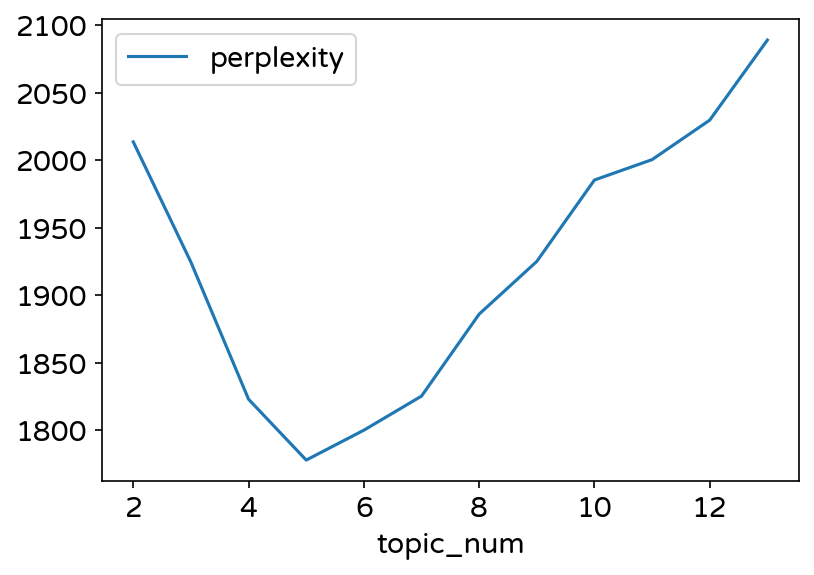

In [26]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

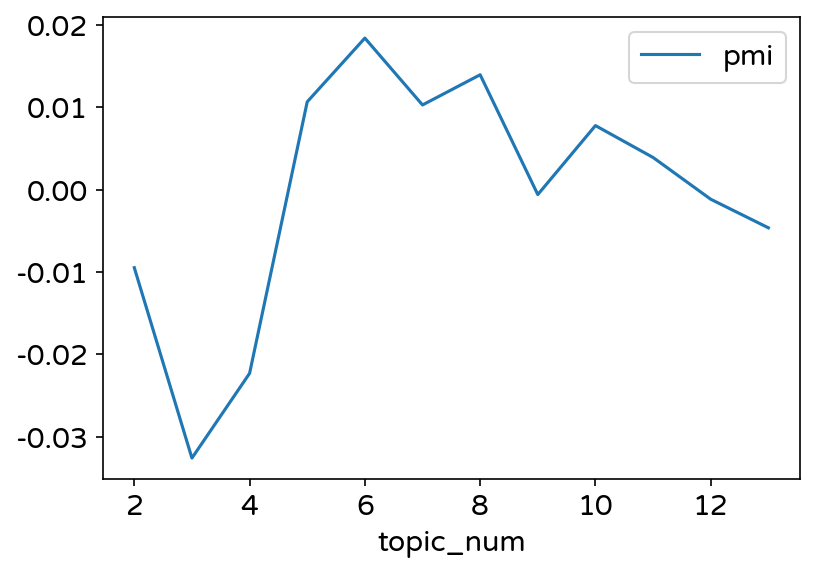

In [27]:
result.plot.line(x='topic_num', y='pmi')

In [31]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 5, #分群
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

In [32]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
p

c:\Users\hands\anaconda3\envs\SMA38\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.122198  0.029487       1        1  28.531100
4      0.117988 -0.021317       2        1  26.521211
3      0.075346  0.053121       3        1  23.466163
0     -0.035959  0.051206       4        1  12.644117
1     -0.035177 -0.112497       5        1   8.837408, topic_info=    Term         Freq        Total Category  logprob  loglift
144   汽車  1431.000000  1431.000000  Default  30.0000  30.0000
27   電動車  2042.000000  2042.000000  Default  29.0000  29.0000
7    特斯拉  2860.000000  2860.000000  Default  28.0000  28.0000
363   中國  1155.000000  1155.000000  Default  27.0000  27.0000
432   充電  1329.000000  1329.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
130   品牌    57.479621   752.070038   Topic5  -5.4457  -0.1452
152   美國    53.195885   550.486967   Topic5  -5.5232   0.0894
162   車輛    50.082767   474.691804   Topic5  -5.5835   0.1772
121   主要    43.015252   204.307449   Topic5  -5.7356   0.8681
212   台灣    42.982548   823.711932   Topic5  -5.7364  -0.5269

[421 rows x 6 columns], token_table=      Topic      Freq Term
term                      
29        1  0.113688   一下
29        2  0.316348   一下
29        3  0.390492   一下
29        4  0.118630   一下
29        5  0.061787   一下
...     ...       ...  ...
3667      1  0.938879   鴻海
3667      2  0.016472   鴻海
3667      3  0.016472   鴻海
3667      4  0.016472   鴻海
3667      5  0.016472   鴻海

[1305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

In [33]:
# 從LDA模型獲取主題詞彙：
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.017*"特斯拉" + 0.012*"充電" + 0.010*"電動車" + 0.006*"駕駛" + 0.005*"現在" + 0.005*"知道" + 0.005*"電車" + 0.005*"問題" + 0.005*"車主" + 0.004*"自動"
Topic: 1 
Words: 0.023*"特斯拉" + 0.021*"電動車" + 0.011*"電池" + 0.010*"汽車" + 0.010*"充電" + 0.009*"車主" + 0.008*"中國" + 0.007*"駕駛" + 0.006*"台灣" + 0.005*"美國"
Topic: 2 
Words: 0.017*"特斯拉" + 0.013*"汽車" + 0.011*"中國" + 0.008*"台灣" + 0.007*"品牌" + 0.007*"電動車" + 0.006*"問題" + 0.006*"駕駛" + 0.006*"充電" + 0.005*"公司"


In [34]:
# 建立詞彙表和詞彙ID對應表
vocab = tuple(dictionary.token2id.keys())
word2id = dictionary.token2id

In [48]:
seed_topic_list = [
    ["服務", "員工", "品質", "後勤", "更換", "速度","態度"],
    ["設備", "交付", "延遲", "據點","原廠"],
    ["價格","優惠","打折","折價"],
    ["安全", "過熱", "火車", "爆炸", "失控","召回","系統","自駕","煞車"],
    ["體驗", "駕駛", "操控", "公差","里程","續航力","加速","噪音","焦慮"],
]

In [49]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [50]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [38]:
# n_topics：指定要生成的主題數量。在這裡設定為4，表示模型將生成4個主題。
# n_iter：指定模型迭代的次數。更多的迭代通常會產生更穩定的結果。在這裡設定為100次。
# random_state：設定隨機種子，以便結果可重現。在這裡設定為2024。
# refresh：指定模型每多少次迭代打印一次當前狀態。在這裡設定為20次，表示每20次迭代會打印一次模型狀態。
#glda_model = guidedlda.GuidedLDA(n_topics=7, n_iter=1000, random_state=2024, refresh=500)
#glda_model.fit(X, seed_topics=seed_topics, seed_confidence=1)

NameError: name 'guidedlda' is not defined

In [51]:
# 整理／顯示主題模型結果
n_top_words = 7
topic_word = glda_model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = glda_model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

NameError: name 'glda_model' is not defined

In [52]:
# 取得每條文章的主題分佈
topics_doc = best_model.get_document_topics(corpus)
topics_doc[100]

[(0, 0.4419318), (1, 0.07783066), (2, 0.06586468), (3, 0.41273892)]

In [53]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.90751803, 0.023119  , 0.02395791, 0.02272329, 0.02268175],
       [0.        , 0.        , 0.        , 0.97063655, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.9932847 ],
       ...,
       [0.99224794, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.23114684, 0.        , 0.75608617, 0.        ],
       [0.01851413, 0.20136163, 0.01837635, 0.74320692, 0.01854093]])

In [54]:
raw_data['topic_label'] = m_theta.argmax(axis=1) + 1

In [55]:
raw_data['topic_label'].value_counts()

5    483
4    379
3    316
1    310
2     97
Name: topic_label, dtype: int64

In [56]:
raw_data.head()

,artDate,content,words,topic_label,month
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"[八卦, 官網, 特斯拉, 二手車, 三方, 平台, 便宜, 黨會, 勝利]",1,2023-01
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"[前輩, 中古, 特斯拉, 里程, 擔心, 電池, 電越, 充越, 少電, 里程數, 越少開...",4,2023-01
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"[王家, 徐兆緯, 台北, 電競, 世界, 冠軍, 日前, 直播, 自動, 駕駛, 雙手, ...",5,2023-01
3,2023-01-02 18:01:04,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"[如題, 特斯拉, 最近, 出門, 車位, 很煩, 騎家裡, 超舊, 機車, 機車道, 機車...",5,2023-01
4,2023-01-02 19:21:24,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"[美國, 汽車, 召回, 排名, 揭曉, 超過, 萬輛車, 進廠, 處理, 結束, 迎來, ...",3,2023-01


In [57]:
raw_data['artDate'] = pd.to_datetime(raw_data['artDate'])

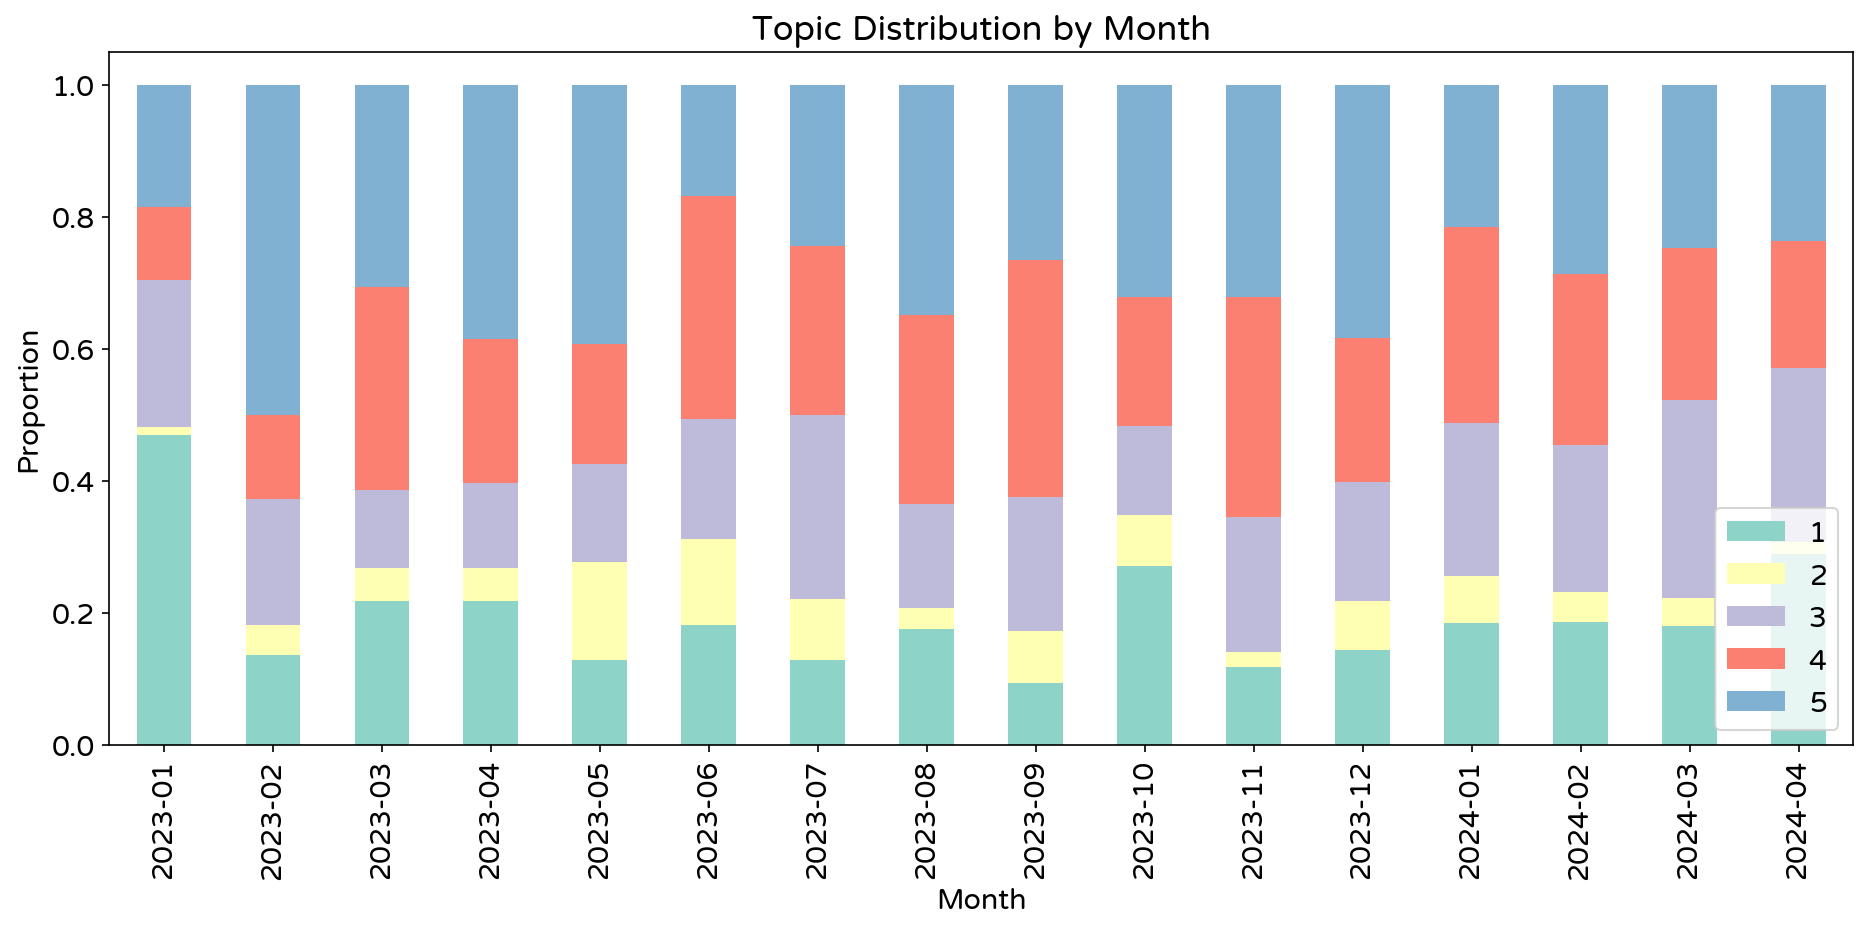

In [58]:
# 以月為單位
raw_data['month'] = raw_data['artDate'].dt.to_period('M')
month_topic = raw_data.groupby(raw_data['month'])['topic_label'].value_counts(normalize=True).unstack()
month_topic.head(3)

fig, ax = plt.subplots(figsize=(15, 6))
month_topic.plot.bar(ax=ax, stacked=True, color=plt.cm.Set3.colors)
ax.legend(loc='lower right')
ax.set_xlabel('Month')
ax.set_ylabel('Proportion')
ax.set_title('Topic Distribution by Month')
plt.show()

In [42]:
# 以日為單位
# raw_data.groupby(raw_data['artDate'].dt.date)['topic_label'].value_counts(normalize=True)
# date_topic = raw_data.groupby(raw_data['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
# date_topic.head()

# fig, ax = plt.subplots(figsize=(15, 6))
# date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
# ax.legend(loc='lower right')

In [46]:
raw_data

,artDate,content,words,topic_label,month
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"[八卦, 官網, 特斯拉, 二手車, 三方, 平台, 便宜, 黨會, 勝利]",1,2023-01
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"[前輩, 中古, 特斯拉, 里程, 擔心, 電池, 電越, 充越, 少電, 里程數, 越少開...",4,2023-01
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"[王家, 徐兆緯, 台北, 電競, 世界, 冠軍, 日前, 直播, 自動, 駕駛, 雙手, ...",5,2023-01
3,2023-01-02 18:01:04,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"[如題, 特斯拉, 最近, 出門, 車位, 很煩, 騎家裡, 超舊, 機車, 機車道, 機車...",5,2023-01
4,2023-01-02 19:21:24,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"[美國, 汽車, 召回, 排名, 揭曉, 超過, 萬輛車, 進廠, 處理, 結束, 迎來, ...",3,2023-01
...,...,...,...,...,...
1581,2024-04-30 10:33:35,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,"[哪有, 那種, 油車, 電動車, 現在, 貨物稅, 美國, 現在, 價格, 簡單, 計算,...",1,2024-04
1582,2024-04-30 12:24:31,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,"[系統性, 改善, 撞車, 問題, 建議, 交通部, 學習, 美國, 特斯拉, 案件, 作法...",5,2024-04
1583,2024-04-30 17:45:19,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,"[轉單, 特斯拉, 買雙, 本板, 多位, 朋友, 想法, 還在, 特斯拉, 搶走, 客群,...",1,2024-04
1584,2024-04-30 19:19:58,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,"[最近, 物色, 台車, 左右, 上週, 特斯拉, 這周, 預算, 用車, 十年, 換車, ...",4,2024-04


In [59]:
data = MetaData.copy()

# 對 'sentence' 欄位應用斷詞函數
data['words'] = data['sentence'].apply(getToken)

# 將 'words' 欄位展開成多行
data = data.explode('words')

# 將展開後的 'words' 欄位重命名為 'word'
data = data.rename(columns={'words': 'word'})

data.head(3)

,artDate,artTitle,artContent,sentence,word
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,官網
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,特斯拉


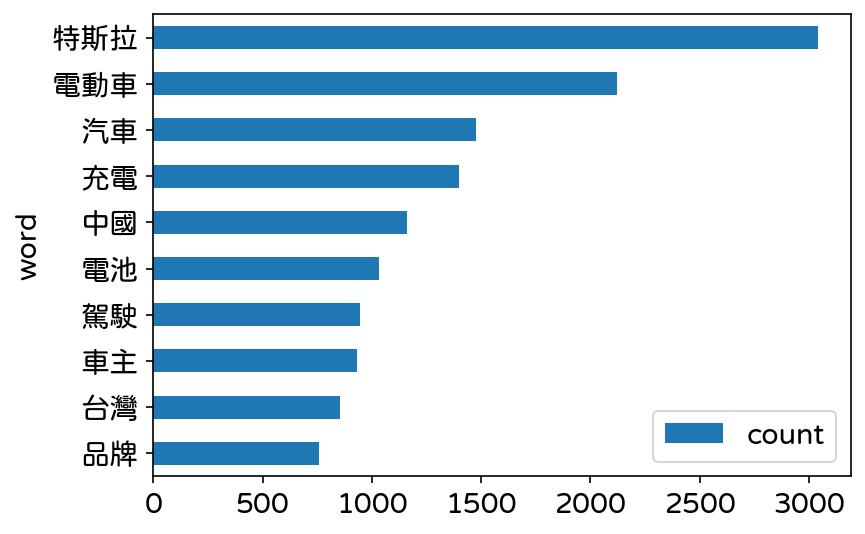

In [60]:
barplot_data = pd.DataFrame(pd.value_counts(data['word'])).reset_index()
barplot_data.columns = ['word','count']
barplot_data = barplot_data.sort_values(by = 'count', ascending = False).reset_index(drop = True)
# barplot_data.to_csv("select_stopword_data.csv", index=False)
barplot_data.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

In [61]:
#新增停用字
stopWords_manual = []
stopWords.extend(stopWords_manual)

# 重新去除停用字
data['word'] = data.sentence.apply(getToken).explode('word')

c:\Users\hands\anaconda3\envs\SMA38\lib\site-packages\jieba\__init__.py:44: DeprecationWarning: invalid escape sequence \.
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
c:\Users\hands\anaconda3\envs\SMA38\lib\site-packages\jieba\__init__.py:46: DeprecationWarning: invalid escape sequence \s
  re_skip_default = re.compile("(\r\n|\s)", re.U)
c:\Users\hands\anaconda3\envs\SMA38\lib\site-packages\jieba\finalseg\__init__.py:78: DeprecationWarning: invalid escape sequence \.
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


KeyboardInterrupt: 

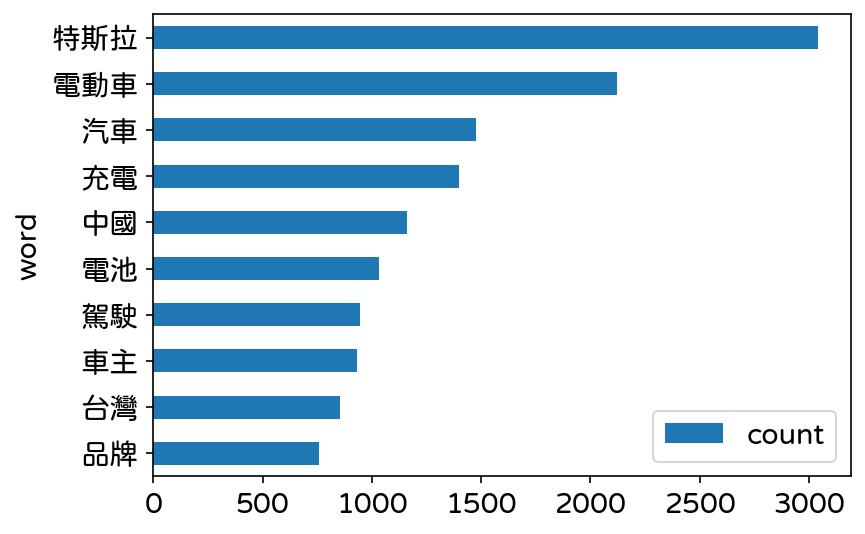

In [62]:
barplot_data = pd.DataFrame(pd.value_counts(data['word'])).reset_index()
barplot_data.columns = ['word','count']
barplot_data = barplot_data.sort_values(by = 'count', ascending = False).reset_index(drop = True)
#barplot_data.to_csv("barplot_data.csv", index=False)
barplot_data.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

In [7]:
HUGGINGFACEHUB_API_TOKEN = getpass()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [8]:
llm = HuggingFaceEndpoint(
    repo_id="google/gemma-1.1-7b-it", temperature=1.0,model_kwargs={'token':HUGGINGFACEHUB_API_TOKEN, 'use_cache':False}
)

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from langchain-huggingface package and should be used instead. To use it run `pip install -U from langchain-huggingface` and import as `from from langchain_huggingface import llms import HuggingFaceEndpoint`.
  warn_deprecated(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/aiden/.cache/huggingface/token
Login successful


In [9]:
MetaData.head()

,artDate,artTitle,artContent,sentence
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...


In [12]:
class ArticleClassification(BaseModel):
    文章分類: str = Field(..., description="分類此文章的主題。", enum=["服務方面", "車輛交付方面", "性價比方面", "安全性方面", "使用者體驗"])
    情緒: str = Field(..., description="判斷整篇文章的總體情緒。", enum=["正向", "中性", "負向"])

article_parser = JsonOutputParser(pydantic_object=ArticleClassification)

In [15]:
# Few-shot Template
fewshot_template = """<start_of_turn>user
你是一個強大的語言模型，能夠根據給定的文本進行分類。
請抓取每一篇文章，進行分類與情緒分類。

1.評論此文章的情緒，正向或負向或中性
2.分類此文章，共有a-e共種分類，請將文章進行分類
    a. 服務方面：特斯拉售前、售後整體過程之服務。
    b. 車輛交付方面：從下訂單到車輛交付的方面。
    c. 性價比方面：衡量特斯拉價格與其所能提供的能力
    d. 安全性方面：特斯拉的主動和被動安全措施、電池安全、充電安全以及整車安全設計等多個方面。
    e. 使用者體驗：從車輛的駕駛感受、操作界面、智慧化功能到軟硬體支援等多個面向的體驗。

以下為一些範例
```
範例1
句子：這款電動車雖然價格不便宜，但確實是物有所值
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"正面",
}}

範例2
句子：特斯拉的客服服務真的很友善，幫助我解決了很多問題
抓取結果：{{
    "文章分類":"服務方面",
    "情緒":"正面",
}}

範例3
句子：我最近買了特斯拉的 Model 3，車輛交付的速度真的很快
抓取結果：{{
    "文章分類":"車輛交付方面",
    "情緒":"正面",
}}

範例4
句子：相同的電動車，特斯拉的蓄電量較低然後又比較貴
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"負面",
}}

範例5
句子：我最近發生了一次車禍，幸好特斯拉的安全措施幫助我避免了更嚴重的損害
抓取結果：{{
    "文章分類":"安全性方面",
    "情緒":"正面",
}}

範例6
句子：特斯拉的操作界面真的很友善，讓我很容易上手
抓取結果：{{
    "文章分類":"使用者體驗",
    "情緒":"正面",
}}

範例7
句子：特斯拉的客服服務真的很慢，需要等很久才能解決問題
抓取結果：{{
    "文章分類":"服務方面",
    "情緒":"負面",
}}

範例8
句子：我最近買了特斯拉的 Model S，車輛交付的速度真的很慢
抓取結果：{{
    "文章分類":"車輛交付方面",
    "情緒":"負面",
}}

範例9
句子：特斯拉的價格真的很高，沒有太多的選擇
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"負面",
}}

範例10
句子：特斯拉的安全措施真的很好，讓我感到很安全
抓取結果：{{
    "文章分類":"安全性方面",
    "情緒":"正面",
}}

範例11
句子：特斯拉的操作界面真的很複雜，需要花很多時間學習
抓取結果：{{
    "文章分類":"使用者體驗",
    "情緒":"負面",
}}

範例12
句子：特斯拉的車子失控，我無法正常駕駛他
抓取結果：{{
    "文章分類":"安全性方面",
    "情緒":"負面",
}}


{format_instructions}
請使用繁體中文回答。
除了 JSON 內容外，不要回答任何其他內容

現在請回答以下問題：
文本：{text}
抓取結果：<end_of_turn>
<start_of_turn>model
"""


article_prompt = PromptTemplate(
    template=fewshot_template,
    input_variables=["text"],
    partial_variables={"format_instructions": article_parser.get_format_instructions()},
)

chain = article_prompt | llm


In [132]:
import json

# 從 json 字串中抓取答案
def extract_answer_from_string(string_):
    string_ = string_.replace("\n", "")
    string_ = string_.replace("json", "")
    string_ = string_.replace("    ", "")
    string_ = string_.replace("```", "")
    try:
        dict_result = json.loads(string_)
    except:
        print(string_)
        return string_
    return dict_result

# 從 dict 抓取情緒
def get_sentiment(row):
    try:
        # 去除多餘的空格和換行符號
        cleaned_row = row.replace(' ', '').replace('\n', '').replace('\r', '')
        # 確保最後一個符號不是逗號
        if cleaned_row.endswith(',}'):
            cleaned_row = cleaned_row.replace(',}', '}')
        data = json.loads(cleaned_row)
        return data.get('情緒', None)
    except (json.JSONDecodeError, TypeError, AttributeError):
        return None

# 從 dict 抓取文章分類
def get_classification(row):
    try:
        # 去除多餘的空格和換行符號
        cleaned_row = row.replace(' ', '').replace('\n', '').replace('\r', '')
        # 確保最後一個符號不是逗號
        if cleaned_row.endswith(',}'):
            cleaned_row = cleaned_row.replace(',}', '}')
        data = json.loads(cleaned_row)
        return data.get('文章分類', None)
    except (json.JSONDecodeError, TypeError, AttributeError):
        return None

In [18]:
# 將MetaData拆分成12份
split_dfs = np.array_split(MetaData, 12)

# 定義一個函數來處理每個分割的資料
def process_split_df(split_df, index):
    split_df['LLM'] = split_df['artContent'].apply(lambda x: extract_answer_from_string(chain.invoke({"text": x})))
    split_df['sentiment'] = split_df['LLM'].apply(get_sentiment)
    split_df['class'] = split_df['LLM'].apply(get_classification)
    split_df.to_csv(f'./data/ppt_tesla_classified_part_{index}.csv', index=False, encoding='UTF-8')

# 逐個處理每個分割的資料
for i in range(0, 12):
    print(f"Processing part {i}")
    process_split_df(split_dfs[i], i)

In [137]:
# 讀取所有 CSV 檔案並合併為一個 DataFrame
llms_class = pd.concat([
    pd.read_csv('./data/ppt_tesla_classified_part_0.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_1.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_2.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_3.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_4.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_5.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_6.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_7.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_8.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_9.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_10.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_11.csv', encoding='UTF-8')
], ignore_index=True)

# 重設 index 並將新的 index 命名為 'system_id'
llms_class = llms_class.reset_index().rename(columns={'index': 'system_id'})
llms_class = llms_class.rename(columns={'情緒': 'sentiment'})
llms_class = llms_class.rename(columns={'文章分類': 'class'})
# 顯示更新後的 DataFrame
llms_class

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",NaN,NaN
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",NaN,NaN
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",NaN,NaN
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",NaN,NaN
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",NaN,NaN
...,...,...,...,...,...,...,...,...
1580,1580,2024-04-30 10:33:35,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",NaN,NaN
1581,1581,2024-04-30 12:24:31,分享撞緩撞車啦,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,"{""文章分類"": ""政策與法規方面"",""情緒"": ""正面"",""內容"": ""要系統性的改善緩撞...",NaN,NaN
1582,1582,2024-04-30 17:45:19,新聞銷售降溫賓士上季獲利銳減逾三成福斯,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,"{""文章分類"": ""使用者體驗"",""情緒"": ""正面""}",NaN,NaN
1583,1583,2024-04-30 19:19:58,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",NaN,NaN


In [138]:
llms_class['sentiment'] = llms_class['LLM'].apply(get_sentiment)
llms_class['class'] = llms_class['LLM'].apply(get_classification)

# 儲存清理後的結果，只保留指定欄位
llms_class.to_csv('./data/ppt_tesla_classified_cleaned.csv', index=False, encoding='UTF-8')
llms_class

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面
...,...,...,...,...,...,...,...,...
1580,1580,2024-04-30 10:33:35,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1581,1581,2024-04-30 12:24:31,分享撞緩撞車啦,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,"{""文章分類"": ""政策與法規方面"",""情緒"": ""正面"",""內容"": ""要系統性的改善緩撞...",正面,政策與法規方面
1582,1582,2024-04-30 17:45:19,新聞銷售降溫賓士上季獲利銳減逾三成福斯,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,"{""文章分類"": ""使用者體驗"",""情緒"": ""正面""}",正面,使用者體驗
1583,1583,2024-04-30 19:19:58,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面


In [139]:
llms_class['class'].value_counts()

class
性價比方面                       569
安全性方面                       460
使用者體驗                       448
服務方面                         18
車輛交付方面                       11
新聞報導                          6
政策方面                          2
性價比方面、使用者體驗                   2
歷史與政策方面                       1
意見與分析                         1
政治及經濟方面                       1
總體觀念                          1
車輛銷量方面                        1
車輛預售方面                        1
保險方面                          1
意見與評估                         1
性價比方面與安全性方面                   1
政治方面                          1
事故報導                          1
法律方面                          1
人工智慧交通運輸汽車科技                  1
性價比方面、使用者體驗、安全性方面、車輛交付方面      1
進口車座談會                        1
性價比方面、使用者體驗、安全性方面             1
車馬費方面                         1
歷史與文化方面                       1
資訊傳遞方面                        1
故事                            1
來源                            1
新聞                            1
進口車銷售方面                       1
政策

In [142]:
df_service = pd.concat([df, llms_class[['system_id','class']]], axis=1)
df_service

,artDate,artTitle,artContent,system_id,class
0,2023-01-01 10:48:19,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,0.0,性價比方面
1,2023-01-01 22:42:25,[問題]特斯拉久了會掉電嗎？,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,1.0,性價比方面
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\nhttps://star.setn.com/news/1232578?utm_...,2.0,使用者體驗
3,2023-01-02 18:01:04,[討論]是不是真的有些四輪覺得自己是大爺？,如題 本身開特斯拉\n\n最近出門覺得找車位很煩都騎家裡超舊機車\n\n基本上在路上有機車道...,3.0,使用者體驗
4,2023-01-02 19:21:24,[新聞]2022美國汽車召回排名揭曉第一名超過8,原文連結：\nhttps://auto.ltn.com.tw/news/21866/3\n原...,4.0,性價比方面
...,...,...,...,...,...
1582,2024-04-30 12:24:31,Re:[分享]TucsonL撞緩撞車啦,要系統性的改善緩撞車被ACC\n撞的問題！\n\n建議交通部學習美國跟特斯拉的案件\n作法，...,1582.0,使用者體驗
1583,2024-04-30 17:45:19,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,****:都轉單到特斯拉了 誰跟你買雙B\n(不針對ID，本板及M01有多位朋友同想法)\n...,1583.0,性價比方面
1584,2024-04-30 19:19:58,[問題]TESLAMODELYVSLEXUSRX350FSPORT,最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...,1584.0,性價比方面
1585,2024-04-30 19:53:28,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,NaN,NaN


In [143]:
df_service = df_service[df_service['class'] == "服務方面"]
df_service

,artDate,artTitle,artContent,system_id,class
16,2023-01-06 22:03:36,[新聞]國道電動車充電站第三期準備招標：8個服,原文連結：\nhttps://bit.ly/3jSrJW2\n原文內容：\n\n國道電動車充...,16.0,服務方面
208,2023-03-06 18:15:18,[電車]特斯拉的停車輔助要加回來？,先前有訂model y\n本來2月收到mail說3月中交車(已降價)，因故我想順延到下個季度...,208.0,服務方面
240,2023-03-15 10:29:52,[新聞]電子廠商爭先搶入電動車，索尼、鴻海、,電子廠商爭先搶入電動車，索尼、鴻海、高通、蘋果和小米各有不同戰略\n\n原文連結：\nhtt...,240.0,服務方面
386,2023-04-28 22:57:48,[新聞]230萬「天坑特斯拉」報廢 建商只丟1句話,原文連結：\nhttps://www.ettoday.net/news/20230428/2...,386.0,服務方面
507,2023-06-07 14:06:37,Re:[新聞]特斯拉2車款遭拒保！國泰產險開第一槍,大家好\n\n這個新聞剛出來的時候\n阿北我有點緊張\n該不會真的沒辦法保吧\n我還真的沒開...,507.0,服務方面
526,2023-06-15 11:22:55,[新聞]Tesla驚喜不斷，限時推出指定車款套件升,原文連結：\nhttps://racingcharger.tw/?p=40530\n原文內容...,526.0,服務方面
596,2023-07-12 07:59:12,[新聞]亞馬遜與Rivian合作，投入電動貨運車隊進,亞馬遜與Rivian合作，投入電動貨運車隊進軍歐洲市場\n\n原文連結：\nhttps://...,596.0,服務方面
650,2023-08-01 00:02:26,[新聞]Comma.ai新版Openpilot內建自動輔助導航自駕功能,原文連結：\nhttps://www.ithome.com.tw/news/158018\n...,650.0,服務方面
922,2023-11-07 17:38:20,[新聞]國內半導體業者持續深耕具發展潛力的車,國內半導體業者持續深耕具發展潛力的車用電子市場\n\n原文連結：\nhttps://bit....,922.0,服務方面
954,2023-11-16 17:24:07,[市調]汽車市場研究活動車馬費800~6000元,本公司目前有5項市場研究專案招募受訪者，\n只要符合各專案的報名資格即可於本公司的活動網頁填...,954.0,服務方面


In [144]:
ws = WS("/Users/aiden/Downloads/data")
pos = POS("/Users/aiden/Downloads/data")
ner = NER("/Users/aiden/Downloads/data")

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2024-06-05 17:24:32.377759: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This cl

In [145]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [146]:
# 自定義辭典
with open('./dict/Tesla_dict.txt') as f:
    lines = f.read().splitlines()

userdict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(userdict)
print(dictionary2)

[(3, {'二手價': 500.0, '充電樁': 500.0}), (4, {'快速道路': 500.0})]


In [147]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [151]:
pos_table, entity_table, sentence_table = get_nlp_result(df_service)

# 花費時間120.5265s

time costing: 8.78088903427124


In [149]:
# 將文章存成csv
pos_table.to_csv("./ckipdata/pos_table_Teala.csv", index = False)
entity_table.to_csv("./ckipdata/entity_table_Tesla.csv", index = False)
sentence_table.to_csv("./ckipdata/sentence_table_Tesla.csv", index = False)

In [153]:
sentence_table = pd.read_csv("./ckipdata/sentence_table_Tesla.csv") #匯入資料
sentiment_date = pd.merge(sentence_table,df_service[['system_id','artDate','artTitle','class']],on='system_id',how='left').dropna()
sentiment_date.head(3)

,system_id,sentence,artDate,artTitle,class
0,16.0,原文連結,2023-01-06 22:03:36,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面
1,16.0,///,2023-01-06 22:03:36,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面
2,16.0,原文內容,2023-01-06 22:03:36,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面


In [154]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,sentence,artDate,artTitle,class,sentimentValue
0,16.0,原文連結,2023-01-06 22:03:36,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.614853
1,16.0,///,2023-01-06 22:03:36,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.250000
2,16.0,原文內容,2023-01-06 22:03:36,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.256389


In [155]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    648.000000
mean       0.420034
std        0.323253
min        0.000039
25%        0.107637
50%        0.404621
75%        0.678930
max        0.999855
Name: sentimentValue, dtype: float64

<Axes: >

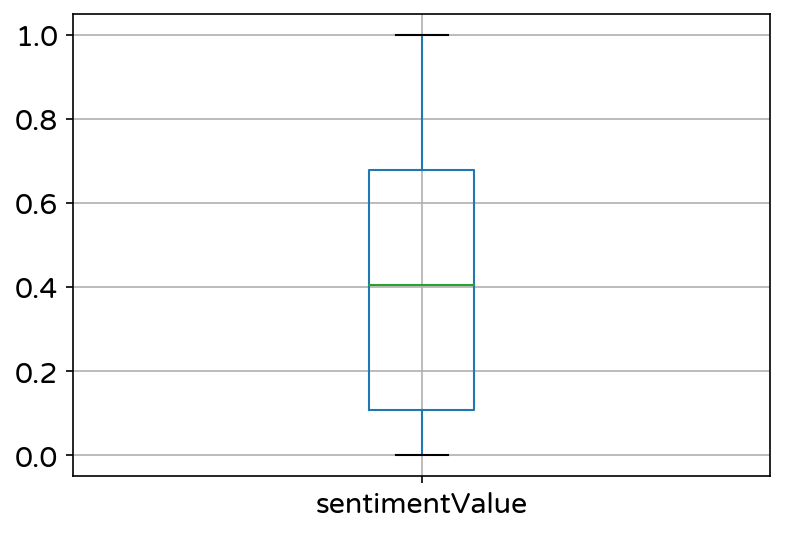

In [156]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [157]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('D')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2023-01-06,0.343402
1,2023-03-06,0.129858
2,2023-03-15,0.614321
3,2023-04-28,0.390462
4,2023-06-07,0.474534
5,2023-06-15,0.350359
6,2023-07-12,0.608032
7,2023-08-01,0.365515
8,2023-11-07,0.411557
9,2023-11-16,0.394045


/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_12935/857956447.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


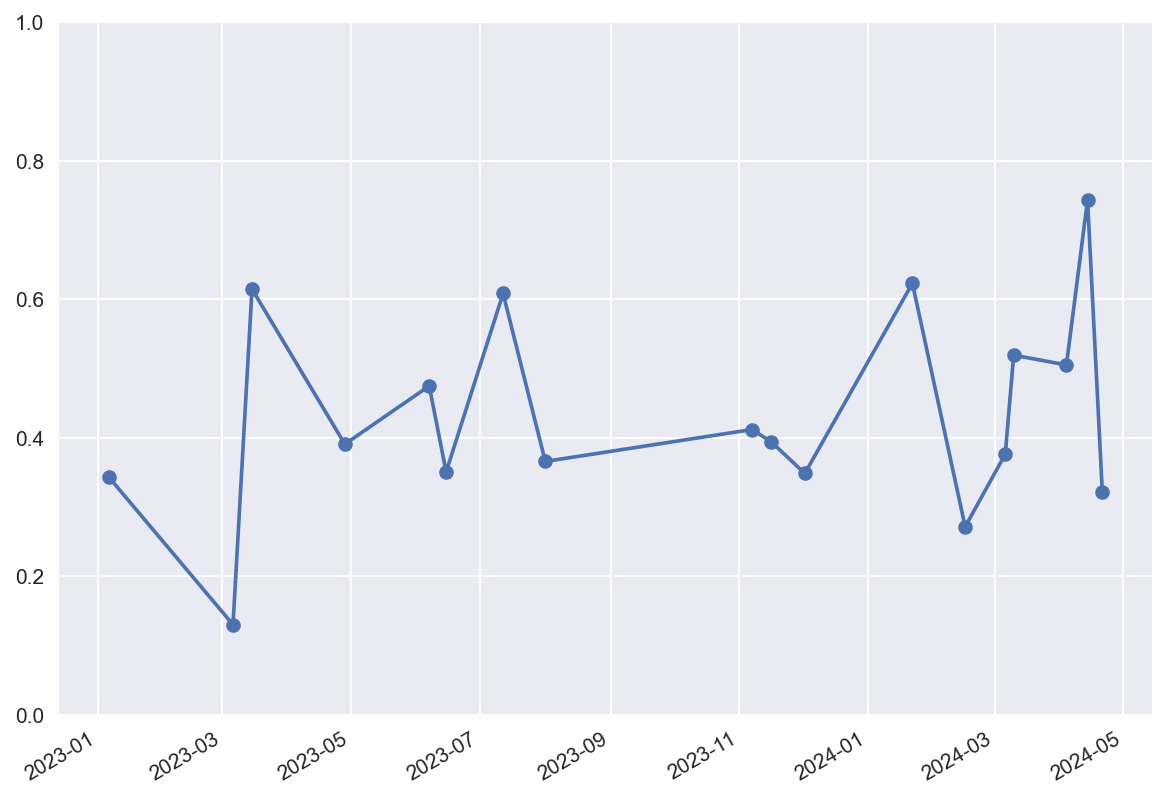

In [158]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

In [159]:
# 篩時間
filter_sentiment = sent_date.loc[sent_date['sentimentValue'] < 0.3]
filter_sentiment.to_csv("filter_sentiment.csv", index = False)
filter_sentiment.head()

,system_id,sentence,artDate,artTitle,class,sentimentValue
1,16.0,///,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.250000
2,16.0,原文內容,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.256389
3,16.0,國道電動車充電站第三期準備招標個服務區蓋座快充站，最低功率起跳,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.000438
4,16.0,國道電動車充電站準備第三期招標，共計個服務區要蓋座快充站，充電設備功率,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.000624
6,16.0,標案預計今年三月份招標，九月前完成評選，預計年,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.000986


In [160]:
filter_sentiment['artTitle']
set(filter_sentiment['artTitle'].tolist())

{'Re:[新聞]小米汽車熱銷公司股價上漲逾16％',
 'Re:[新聞]特斯拉2車款遭拒保！國泰產險開第一槍\u3000',
 '[問題]為什麼中國電車那麼厲害？',
 '[市調]汽車市場研究活動車馬費800~6000元',
 '[情報]2023年歐洲汽車市場銷量分析',
 '[情報]特斯拉推遲(或取消)平價車計畫',
 '[情報]特斯拉柏林廠空拍拍到疑似新型小車',
 '[新聞]230萬「天坑特斯拉」報廢\u3000建商只丟1句話',
 '[新聞]Comma.ai新版Openpilot內建自動輔助導航自駕功能',
 '[新聞]Tesla驚喜不斷，限時推出指定車款套件升',
 '[新聞]亞馬遜與Rivian合作，投入電動貨運車隊進',
 '[新聞]國內半導體業者持續深耕具發展潛力的車',
 '[新聞]國道電動車充電站第三期準備招標：8個服',
 '[新聞]沒充電站…特斯拉車主從住家2樓拉電線台',
 '[新聞]趙小蘭妹妹生前最後一刻情況曝\u3000駕特斯',
 '[新聞]電子廠商爭先搶入電動車，索尼、鴻海、',
 '[電車]特斯拉的停車輔助要加回來？'}

In [161]:
# Define the regular expression pattern for special symbols
sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：_/\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'

# Remove special symbols from the 'sentence' column
filter_sentiment['sentence'] = filter_sentiment['sentence'].apply(lambda x: re.sub(sepical_symbols, '', x))
filter_sentiment = filter_sentiment[filter_sentiment['sentence'] != '']

# Save the filtered DataFrame to a CSV file
filter_sentiment.to_csv("filter_sentiment.csv", index=False)

# Display the first few rows of the filtered DataFrame
filter_sentiment.head()

/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_12935/2690932689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_sentiment['sentence'] = filter_sentiment['sentence'].apply(lambda x: re.sub(sepical_symbols, '', x))


,system_id,sentence,artDate,artTitle,class,sentimentValue
2,16.0,原文內容,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.256389
3,16.0,國道電動車充電站第三期準備招標個服務區蓋座快充站，最低功率起跳,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.000438
4,16.0,國道電動車充電站準備第三期招標，共計個服務區要蓋座快充站，充電設備功率,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.000624
6,16.0,標案預計今年三月份招標，九月前完成評選，預計年,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.000986
11,16.0,第期由中興電工得標，與合作經營東山清水湖口南北共四,2023-01-06,[新聞]國道電動車充電站第三期準備招標：8個服,服務方面,0.002049


In [162]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment, pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

,system_id,sentimentValue,word
0,16.0,0.256389,原文
1,16.0,0.256389,連結
2,16.0,0.256389,///
3,16.0,0.256389,原文
4,16.0,0.256389,內容


In [163]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

In [164]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['來源', '市場', '排行', '大神', '目前', '是不是', '也將', '紅', '通知', '讀版', '圖片', '以下', '需要', '連結', '記者', '署名', '發文', '發布', '時間', '心得', '評論', '正文', '張數', '原文', '標題', '網址', '內文', '口', '張數', '家數', '年月日', '單位', '統計', '證券', '名稱', '交易所', '代號', '謝謝', '分類', '標的', '報導', '格式', '股票名稱', '業者', '依板', '版規', '刪除', '內容', '未依', '規處份', '輸入', '文處份', '處份', '股號', '板規', '股名', '類免', '第四季', '原文', '萬輛', '$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '進行', '昨天', '不惟', '不成', '10', '拿下', '去年', '希望', '11', '提供', '記者', '報導', '表示', '不用', 'app', '12', '繼續', '成為', '表現', '今天', '今年', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎

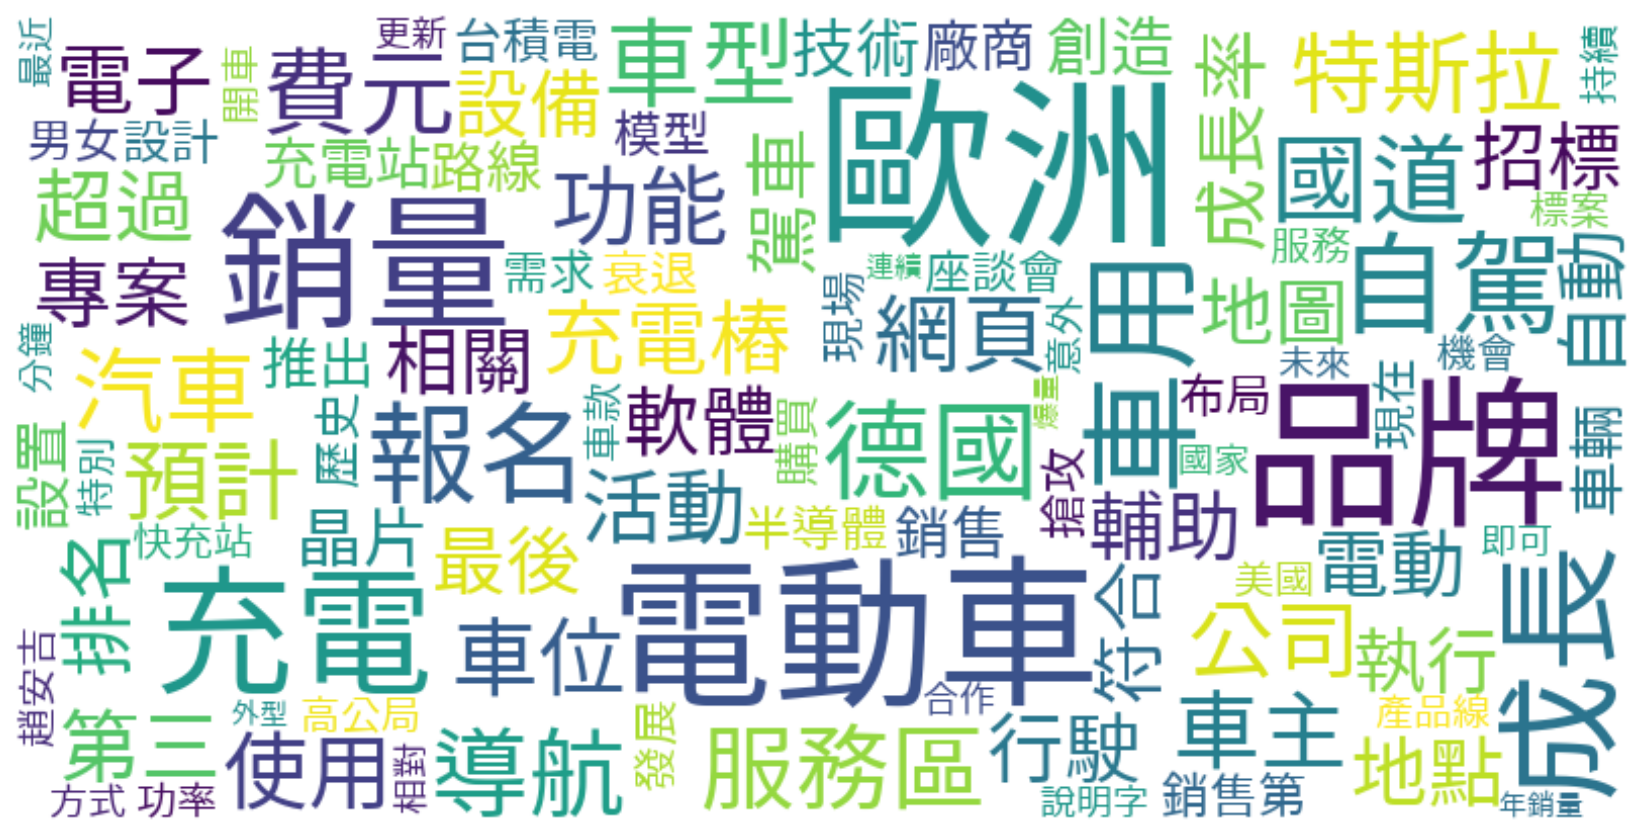

In [165]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
#stop_words_pos.extend((最多','提供'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()